In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_path = '/kaggle/input/ue19cs312-assignment/train.csv'
test_path = '/kaggle/input/ue19cs312-assignment/test.csv'

In [4]:
# importing dataset
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
df.head()

In [5]:
# descriptive statistics
print('Descriptive statistics')
print(df.describe())
# print null values
print('Null values')
print(df.isnull().sum())
# print shape of dataframe
print('Shape of dataframe')
print(df.shape)

In [6]:
# convert to datetime
df['Date'] = pd.to_datetime(df['Date'])
# make a copy of the dataframe
df_copy = df.copy()
# plot the Close column
xlabel = 'Year'
ylabel = 'Close'
df_copy['Close'].plot(xlabel=xlabel, ylabel=ylabel,figsize=(12,6))
plt.title('Closing Price over the years')
plt.show()


# Multiple Linear Regression

Regression models are used to describe relationships between variables by fitting a line to the observed data. Regression allows you to estimate how a dependent variable changes as the independent variable(s) change.

Multiple linear regression is used to estimate the relationship between two or more independent variables and one dependent variable. You can use multiple linear regression when you want to know:

How strong the relationship is between two or more independent variables and one dependent variable (e.g. how rainfall, temperature, and amount of fertilizer added affect crop growth).
The value of the dependent variable at a certain value of the independent variables (e.g. the expected yield of a crop at certain levels of rainfall, temperature, and fertilizer addition).

Multiple linear regression formula

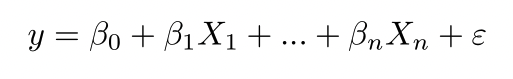

**$y$** = the predicted value of the dependent variable

**$\beta_0$** = the y-intercept (value of y when all other parameters are set to 0)

**$\beta_1X_1$** = the regression coefficient ($\beta_1$) of the first independent variable ($X_1$) (i.e the effect that increasing the value of the independent variable has on the predicted y value)

**…** = do the same for however many independent variables you are testing

**$\beta_nX_n$** = the regression coefficient of the last independent variable

**$\epsilon$** = model error (i.e how much variation there is in our estimate of y)

## Assumptions of multiple linear regression

Multiple linear regression makes all of the same assumptions as simple linear regression:

Homogeneity of variance (homoscedasticity): the size of the error in our prediction doesn’t change significantly across the values of the independent variable.

Independence of observations: the observations in the dataset were collected using statistically valid methods, and there are no hidden relationships among variables.

In multiple linear regression, it is possible that some of the independent variables are actually correlated with one another, so it is important to check these before developing the regression model. If two independent variables are too highly correlated (r2 > ~0.6), then only one of them should be used in the regression model.

Normality: The data follows a normal distribution.

Linearity: the line of best fit through the data points is a straight line, rather than a curve or some sort of grouping factor.

### Feature Engineering

We will now perform feature engineering to generate additional features for the model. These features are derived from the given dataset itself. These features also highlight some common price trends that helps the model to predict better.

1. **M16** : Moving Average 16 is calculated on the open price. M16 uses a window of 16 days and calculates the values based on the past 16 moving average of the open price.
2. **M50** : Moving Average 50 is calculated on the open price. M16 uses a window of 50 days and calculates the values based on the past 50 moving average of the open price.
3. **Buy** : If M16 is greater than M50, it gives an indication that the price could go up mode in next few days. Hence Buy = 1 if M16 > M50 else 0.
4. **Short** : This is opposite of Buy. If M16 < M50, then 1 else 0. Short indicates that the price could drop in the next few days
5. **Sentiment** : Uses High and Low to indicate the trend of the price in a trading day. If High - Low < 0 then it indicates a down trend else an uptrend.
6. **ROI** : Stands for Return on Investment. Basically tracks the percentage increase in stock price since the first price of the dataset.
7. **Percent Change** : Percentage Increase or decrease in stock price compared to previous trading day.
8. **VPT** : Volume Price Trend Indicator is used to give strength of a upward or downward trend.

Note : Not all features have been used for making predictions.

In [7]:
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

DF = pd.concat([df,test_df])
DF = DF.reset_index(drop=True)
DF['M16'] = DF['Open'].rolling(16).mean()
DF['M50'] = DF['Open'].rolling(50).mean()
DF['M16'] = DF['M16'].fillna(method="bfill")
DF['M50'] = DF['M50'].fillna(method="bfill")
DF['Buy'] = np.where(DF['M16']>DF['M50'],1.0,0.0)
DF['Short'] = np.where(DF['M16']<DF['M50'],1.0,0.0)
DF['roi'] = (DF['Open'] - DF['Open'][0])/DF['Open'][0]
DF['sentiment'] = np.where(DF['High']-DF['Low']<0,0.0,1.0)
DF['percent_change'] = (DF['Open'] - DF['Open'].shift(1))/DF['Open'].shift(1)
DF['percent_change'] = DF['percent_change'].fillna(0)
DF['Date'] = pd.to_datetime(DF['Date'])
DF['VPT'] = 0
DF['VPT'] = DF['VPT'].shift(1) + (DF['Volume'] * (DF['Open']-DF['Open'].shift(1))/DF['Open'].shift(1))
DF['VPT'] = DF['VPT'].fillna(method='bfill')
DF = DF.set_index('Date')
df = DF[:1500]
test_df = DF[1500:]

### Scaling the data by standard scaler

In [8]:
sc1 = StandardScaler()
sc2 = StandardScaler()
columns = ['Open','High','Low','Volume','roi','M16','M50','percent_change']
df[columns] = sc1.fit_transform(df[columns])
test_df[columns] = sc1.transform(test_df[columns])
df['Close'] = sc2.fit_transform(df[['Close']].values.reshape(-1,1))

In [9]:
LR = LinearRegression()
LR.fit(df[columns][:1400],df['Close'][:1400])
y_prediction =  LR.predict(df[columns][1400:1500])

### RMSE of MLR model

In [10]:
print("rmse :", np.sqrt(mean_squared_error(sc2.inverse_transform(df['Close'][1400:1500].values.reshape(-1,1)),sc2.inverse_transform(y_prediction.reshape(-1,1)))))

### Predictions of MLR on test data

In [11]:
y_test_prediction = sc2.inverse_transform(LR.predict(test_df[columns]).reshape(-1,1))
y_test_prediction

## Drawbacks of MLR model in Time Series Forecasting

The problem arises from the fact that ordinary least squares does not work for Time Series Data.

The principal reason for this is : Autocorrelation.

You can’t assume that the errors are independent and identically distributed (i.i.d.) or your model will be inaccurate.

There are ways of getting around that and using regression, but they are limited.

For example you could compute the difference between two different times:

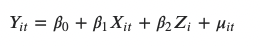

where Z is a factor which does not change overtime (but changes over entities).

Then, you could build a linear model of the difference:

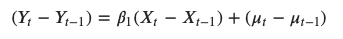

Another reason that linear regression for time series is a bad ‘fit’ has to do with sampling. In a non time series framework it is reasonable to assume that each variable is a mere sample from a larger population that can take on many values according to some distribution. And regression methods take that into account.

With time series regression, we are just seeing just one realization of a sampling sequence which has been generated from some unknown stochastic process. In a different sample, we could see a slightly different result. However we usually never consider alternate time series sequences, but rely on that one fixed sequence that history has played out.

# AR Time Series Model

An autoregressive (AR) model predicts future behavior based on past behavior. It’s used for forecasting when there is some correlation between values in a time series and the values that precede and succeed them. You only use past data to model the behavior, hence the name autoregressive (the Greek prefix auto– means “self.” ). The process is basically a linear regression of the data in the current series against one or more past values in the same series.

In an AR model, the value of the outcome variable ($Y$) at some point $t$ in time is — like “regular” linear regression — directly related to the predictor variable ($X$). Where simple linear regression and AR models differ is that Y is dependent on $X$ and previous values for $Y$.

The AR process is an example of a stochastic process, which have degrees of uncertainty or randomness built in. The randomness means that you might be able to predict future trends pretty well with past data, but you’re never going to get 100 percent accuracy. Usually, the process gets “close enough” for it to be useful in most scenarios.

AR models are also called conditional models, Markov models, or transition models.

An $AR(p)$ model is an autoregressive model where specific lagged values of $y_t$ are used as predictor variables. Lags are where results from one time period affect following periods.

The value for $p$ is called the order. For example, an $AR(1)$ would be a “first order autoregressive process.” The outcome variable in a first order AR process at some point in time $t$ is related only to time periods that are one period apart (i.e. the value of the variable at $t – 1$). A second or third order AR process would be related to data two or three periods apart.

The $AR(p)$ model is defined by the equation:

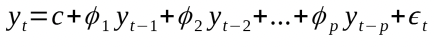

Where:
1. $y_{t-1}$, $y_{t-2}, … ,y_{t-p}$ are the past series values (lags),
2. $\epsilon_t$ is white noise (i.e. randomness)

## Assumptions of AR Model :

One of the fundamental assumptions of AR model is that the time series is assumed
to be a stationary process.
If a time-series data, $y_t$, is stationary, then it satisfies the following conditions:
1. The mean values of $y_t$ at different values of t are constant.
2. The variances of $y_t$ at different time periods are constant (Homoscedasticity).
3. The covariances of $y_t$ and $y_{t-k}$ for different lags depend only on $k$ and not on time $t$.

Another important concept associated with forecasting based on regression-based
models is the white noise of residuals. White noise is a process of residuals are
uncorrelated and follow normal distribution with mean 0 and constant standard
deviation. In AR models, one of the important assumptions that we make is that the
errors follow a white noise.


In [12]:
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [13]:
# rolling statistics
rolmean = df['Close'].rolling(window=12).mean()
rolstd = df['Close'].rolling(window=12).std()

In [14]:
# plot rolling statistics
orig = plt.plot(df['Close'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [15]:
# Dickey-Fuller test
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Close'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)

## Test for Stationarity

Performing the Augmented Dickey Fuller Test to check if our data is stationary or not. 

The hypothesis used for the test are as follows : 
1. $H_o$ : Data is not stationary
2. $H_a$ : Data is stationary

On performing the `adfuller_test`,

$Hypothesis = \begin{cases} 
  H_o & p\_value\geq 0.05 \\
  H_a & p\_value\leq 0.05 
\end{cases}$



In [16]:
# Test for Stationarity
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [17]:
adfuller_test(df['Close'])

### Decomposing the Time series data into Trend, Seasonality and Residuals

The time series data is composed of three components, trend, seasonality and residuals. Trend indicates the overall trend in data. Seasonality indicates any seasonal patterns in the dataset. Residuals are just white noise that is left after removing the trend and seasonality in time series data

In [18]:
decomposition = seasonal_decompose(df['Close'], freq=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[1300:1500], label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show(block=False)

In [20]:
df_stationary = df.copy()
df_stationary['Close First Difference'] = df['Close'] - df['Close'].shift(1)
df_stationary['Close Second Difference'] = df['Close'] - df['Close'].shift(2)

### Test for stationarity after performing first difference

In [21]:
adfuller_test(df_stationary['Close First Difference'].dropna())

### Test for stationarity after performing second difference

In [22]:
adfuller_test(df_stationary['Close Second Difference'].dropna())

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df_stationary['Close First Difference'], label='Close First Difference')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df_stationary['Close Second Difference'].dropna(), label='Close Second Difference')
plt.legend(loc='best')
plt.tight_layout()
plt.show(block=False)

### Decomposing the Time series data into Trend, Seasonality and Residuals

The time series data is composed of three components, trend, seasonality and residuals. Trend indicates the overall trend in data. Seasonality indicates any seasonal patterns in the dataset. Residuals are just white noise that is left after removing the trend and seasonality in time series data

In [24]:
# checking for stationarity
# decomposition
decomposition = seasonal_decompose(df_stationary['Close Second Difference'].dropna(), freq=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot Trend, Seasonality and Residuals
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_stationary['Close Second Difference'].dropna(), label='Close Second Difference')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[1300:1500], label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show(block=False)

In [25]:
csd = pd.DataFrame(df_stationary['Close Second Difference'].dropna())
csd = csd.reset_index(drop=True)

## Autocorrelation and Partial Autocorrelation

The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF) For example the ACF for a time series $y_t$ is given by:

$Corr(y_t,y_{t-k})$

This value of $k$ is the time gap being considered and is called the lag. A lag 1 autocorrelation (i.e., $k = 1$ in the above) is the correlation between values that are one time period apart. More generally, a lag $k$ autocorrelation is the correlation between values that are $k$ time periods apart.

The ACF is a way to measure the linear relationship between an observation at time t and the observations at previous times. If we assume an AR($k$) model, then we may wish to only measure the association between $y_t$ and $y_{t−k}$ and filter out the linear influence of the random variables that lie in between (i.e. $y_{t-1},y_{t-2},...,y_{t-(k-1)}$), which requires a transformation on the time series. Then by calculating the correlation of the transformed time series we obtain the partial autocorrelation function (PACF).

The PACF is most useful for identifying the order of an autoregressive model. Specifically, sample partial autocorrelations that are significantly different from 0 indicate lagged terms of $y$ that are useful predictors of $y_t$. To help differentiate between ACF and PACF, think of them as analogues to $R^2$ and partial $R^2$ values.

Graphical approaches to assessing the lag of an autoregressive model include looking at the ACF and PACF values versus the lag. In a plot of ACF versus the lag, if you see large ACF values and a non-random pattern, then likely the values are serially correlated. In a plot of PACF versus the lag, the pattern will usually appear random, but large PACF values at a given lag indicate this value as a possible choice for the order of an autoregressive model. It is important that the choice of the order makes sense. For example, suppose you have blood pressure readings for every day over the past two years. You may find that an AR(1) or AR(2) model is appropriate for modeling blood pressure. However, the PACF may indicate a large partial autocorrelation value at a lag of 17, but such a large order for an autoregressive model likely does not make much sense

In [26]:
# ACF and PACF 
lag_acf = acf(csd, nlags=20)
lag_pacf = pacf(csd, nlags=20, method='ols')

### Autocorrelation Function plot

In [27]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(csd)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(csd)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

### Partial Autocorrelation Function plot

In [28]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(csd)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(csd)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show(block=False)

In [29]:
close = csd
# preparing train and test data for Auto Reression Model
train = close[:len(close)-10]
test = close[len(close)-10:]

### Transforming our dataset using Standard Scaler and Training the AR Model

In [30]:
# Transform train and test data by applying StandardScaler
scaler = StandardScaler()
train = scaler.fit_transform(train.values.reshape(-1,1))
test = scaler.transform(test.values.reshape(-1,1))

In [31]:
# fit AR model
AR_model = AutoReg(train, lags=10).fit()

### Predictions on test data

In [32]:
predictions_AR = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions_AR = scaler.inverse_transform(predictions_AR.reshape(-1,1))


### Calculating RMSE of AR model on test set.

In [33]:
rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(test), predictions_AR))
print(rmse)

In [34]:
# plot predictions
plt.plot(scaler.inverse_transform(test), label='Test Data')
plt.plot(predictions_AR, label='Predictions')
plt.legend(loc='best')
plt.title('Predictions vs Actuals')
plt.show(block=False)


### Plotting the Residual Errors

Residual errors show how off the model predictions are compared to the ground truth values. It can be calculated by taking the difference between the actual or the true values and the predicted values.

In [35]:
residuals = pd.DataFrame(test-predictions_AR, columns=['Residuals'])
residuals.plot()
plt.title('Residuals')
plt.show()
residuals.plot(kind='kde')
plt.title('Density')
plt.show()
print('Residuals: %.2f' % np.mean(residuals.values))

## Drawbacks of AR Model in time series forecasting :

1. AR is a forecasting method for univariate time series data.
2. Not able to capture fluctuations in data since its does not take into account the seasonal differences and seasonal moving-average terms i.e it does not support seasonal data
3. Needs data to be stationary.
4. If the beta parameter is greater then 1 it will result in infinetly large values and if its estimated as 1, the the future value depends on the entire past (and will lead to non-stationarity). For practical applications, the value of beta should be less than one.

# Seasonal ARIMAX Time Series Model

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.

Although the method can handle data with a trend, it does not support time series with a seasonal component.

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA. The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

#### Trend Elements

There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

$p$: Trend autoregression order.

$d$: Trend difference order.

$q$: Trend moving average order.

#### Seasonal Elements

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

$P$: Seasonal autoregressive order.

$D$: Seasonal difference order.

$Q$: Seasonal moving average order.

$m$: The number of time steps for a single seasonal period.

A grid search can be used across the trend and seasonal hyperparameters. Together, the notation for an SARIMA model is specified as:

$SARIMA(p,d,q)(P,D,Q)m$



### Assumptions of SARIMA Model

One of the assumptions of SARIMA model is that, for a good model, the residuals must follow a white noise process. That is, the residuals have zero mean, constant variance and also uncorrelated.

$p,d,q$ can take values in [0,1,2].

$P,D,Q$ should be never larger than 1.

No explicit seasonal indices, hard to interpret coefficients or explain “how the model works”, danger of overfitting or misidentification if not used with care.

### Feature Engineering

We will now perform feature engineering to generate additional features for the model. These features are derived from the given dataset itself. These features also highlight some common price trends that helps the model to predict better.

1. **M16** : Moving Average 16 is calculated on the open price. M16 uses a window of 16 days and calculates the values based on the past 16 moving average of the open price.
2. **M50** : Moving Average 50 is calculated on the open price. M16 uses a window of 50 days and calculates the values based on the past 50 moving average of the open price.
3. **Buy** : If M16 is greater than M50, it gives an indication that the price could go up mode in next few days. Hence Buy = 1 if M16 > M50 else 0.
4. **Short** : This is opposite of Buy. If M16 < M50, then 1 else 0. Short indicates that the price could drop in the next few days
5. **Sentiment** : Uses High and Low to indicate the trend of the price in a trading day. If High - Low < 0 then it indicates a down trend else an uptrend.
6. **ROI** : Stands for Return on Investment. Basically tracks the percentage increase in stock price since the first price of the dataset.
7. **Percent Change** : Percentage Increase or decrease in stock price compared to previous trading day.
8. **VPT** : Volume Price Trend Indicator is used to give strength of a upward or downward trend.

Note : Not all features have been used for making predictions.

### Creating the Training and Testing splits

After performing feature engineering, we will use those as additional features that the model could use to make predictions. We will create two splits, Tuning_split and Testing_split. Tuning_split will be used for tuning our model to make better predictions. Testing_split will be used to train our model on the complete training set provided to us. Tuning_split consists of a training split, validation split and a test split. The training split consists of 1400 examples, validation split consists of 100 examples and the test split consists of 30 examples. The tuning split consists of two things, training split and a test split. Training split consists of 1500 examples and test split consists of 30 examples.

In [36]:
def create_dataset(train_path,test_path):
    df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    DF = pd.concat([df,test_df])
    DF = DF.reset_index(drop=True)
    DF['M16'] = DF['Open'].rolling(16).mean()
    DF['M50'] = DF['Open'].rolling(50).mean()

    DF['M16'] = DF['M16'].fillna(method="bfill")
    DF['M50'] = DF['M50'].fillna(method="bfill")

    DF['Buy'] = np.where(DF['M16']>DF['M50'],1.0,0.0)
    DF['Short'] = np.where(DF['M16']<DF['M50'],1.0,0.0)
    DF['sentiment'] = np.where(DF['High']-DF['Low']<0,0.0,1.0)
    
    
    DF['roi'] = (DF['Open'] - DF['Open'][0])/DF['Open'][0]
    DF['percent_change'] = (DF['Open'] - DF['Open'].shift(1))/DF['Open'].shift(1)
    DF['percent_change'] = DF['percent_change'].fillna(0)
    
    DF['VPT'] = 0
    DF['VPT'] = DF['VPT'].shift(1) + (DF['Volume'] * (DF['Open']-DF['Open'].shift(1))/DF['Open'].shift(1))
    DF['VPT'] = DF['VPT'].fillna(method='bfill')
    
    DF['Date'] = pd.to_datetime(DF['Date'])
    DF = DF.reset_index(drop=True)
    df = DF[:1400]
    val_df = DF[1400:1500]
    test_df = DF[1500:]
    return ((df.reset_index(drop=True),val_df.reset_index(drop=True),test_df.reset_index(drop=True)),(DF[:1500].reset_index(drop=True),DF[1500:].reset_index(drop=True)))

In [37]:
tuning_split,testing_split = create_dataset(train_path,test_path)

#### Transforming our dataset using Standard Scaler

In [38]:
df,val_df,test_df = tuning_split

sc1 = StandardScaler()
sc2 = StandardScaler()

columns = ['Open','Volume','High','Low','M16','M50','roi','VPT','percent_change']
df[columns] = sc1.fit_transform(df[columns])
val_df[columns] = sc1.transform(val_df[columns])
test_df[columns] = sc1.transform(test_df[columns])

df['Close'] = sc2.fit_transform(df[['Close']])

## Training SARIMAX on the training split

A SARIMAX model is used to train on the training split. The training split contains 1400 examples. The model will then be evaluated on a hold out validation set. This will give us a rough idea on how our model performs on data it has not seen. This will help us tune our model properly and help us get a lower RMSE score on testing set.

In [39]:
model = SARIMAX(endog=df['Close'],exog=df[columns],order=(2,0,0),seasonal_order=(0,1,2,16),trend=[1,0,1,1],trend_offset=7,enforce_invertibility=False,enforce_stationarity=False,start_params=[0,0,1,0,1,2,1,2])
model_fit = model.fit(disp=0,maxiter=100,cov_type="robust",method="lbfgs")

## Visualizing the Predictions

We will use the trained model to make predictions on our validation set and evaluate the model using RMSE metric. We will also plot the predictions on the actual ground truth values. 

In [40]:
val_predictions = model_fit.forecast(steps=100,exog=val_df[columns],dynamic=False)
val_predictions = sc2.inverse_transform(val_predictions)
val_predictions

In [41]:
pred = pd.Series(val_predictions.reshape(-1),name='predicted_mean',index=val_df['Close'].index)
ans = pd.concat([val_df['Close'].reset_index(drop=True),pred],axis=1)
ans.plot()

In [42]:
rmse = math.sqrt(mean_squared_error(val_df['Close'],val_predictions))
rmse

### Training the model on entire training split

The original training set was split into two parts so that we could perform model evaluation on the validation set. This gives us a rough idea on how the model performs on data that the model has not seen or in other words we would like to measure how model performs on out of sample data instances. This will also help us check if our model has overfit to our training set. 

In [43]:
df,test_df = testing_split
sc1 = StandardScaler()
sc2 = StandardScaler()
columns = ['Open','Volume','High','Low','M16','M50','roi','VPT','percent_change']
df[columns] = sc1.fit_transform(df[columns])
val_df[columns] = sc1.transform(val_df[columns])
test_df[columns] = sc1.transform(test_df[columns])
df['Close'] = sc2.fit_transform(df[['Close']])

model = SARIMAX(df['Close'],exog=df[columns],order=(2,0,0),seasonal_order=(0,1,2,16), trend=[1,0,1,1], trend_offset=7,enforce_invertibility=False,enforce_stationarity=False,start_params=[0,0,1,0,1,2,1,2])
model_fit = model.fit(disp=0,maxiter=100,cov_type="robust",method="lbfgs")

### Making Predictions using the model

After training the $SARIMAX$ model, we will use it to make predictions on the training set as well the test set. The predictions on the training set will be used to evaluate the model performance and the predictions on the test set will be used for submission.

In [44]:
future = model_fit.forecast(steps=len(test_df),exog=test_df[columns],dynamic=False)
future = sc2.inverse_transform(future)

pred = model_fit.predict(start=1400,end=1499,exog=df[columns],dynamic=False)
pred = sc2.inverse_transform(pred)

df['Close'] = sc2.inverse_transform(df['Close'].values.reshape(-1,1))
pred = pd.Series(pred.reshape(-1),name='predicted_mean',index=df['Close'][1400:].reset_index(drop=True).index)
ans = pd.concat([df['Close'][1400:].reset_index(drop=True),pred],axis=1)
ans.plot()

### Calculating the RMSE score obtained on training set

After training the $SARIMAX$ model, we will check the RMSE score that we obtain on couple of examples from the training set. This will show how well the model has fit the training set.

In [45]:
rmse = math.sqrt(mean_squared_error(df['Close'][1400:],pred))
rmse

### Plotting the Residual Errors

Residual errors show how off the model predictions are compared to the ground truth values. It can be calculated by taking the difference between the actual or the true values and the predicted values.

In [46]:
residuals = pd.DataFrame(df['Close'][1400:].reset_index(drop=True)-pred, columns=['Residuals'])
residuals.plot()
plt.title('Residuals')
plt.show()
residuals.plot(kind='kde')
plt.title('Density')
plt.show()
print('Residuals: %.2f' % np.mean(residuals.values))

### Preparing for submission

The predictions obtained from the $SARIMAX$ model is converted to a dataframe and the corresponding dates are concatenated.

In [47]:
test_df = pd.read_csv(test_path)
date = test_df['Date']
pred_future = pd.Series(future.reshape(-1), name='Close')
pred_future.reset_index(drop = True, inplace = True)
submission_df = pd.concat([date, pred_future], axis = 1)
submission_df

In [48]:
# submission_df.to_csv('submission.csv', index = False)